In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

## 1. EDA

#### Load dataset

In [3]:
titanic= pd.read_csv("C:\\Users\\hp\\Desktop\\Titanic_train.csv")
titanic

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [5]:
titanic.shape

(891, 12)

In [7]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [9]:
# dropping the unnecessary columns as it is not required
titanic.drop(["PassengerId","Name","Ticket","Cabin"],inplace=True,axis = 1)

#### Check missing values

In [11]:
titanic.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [13]:
titanic[titanic.isnull().any(axis=1)].shape

(179, 8)

#### Explore data distribution

<Axes: >

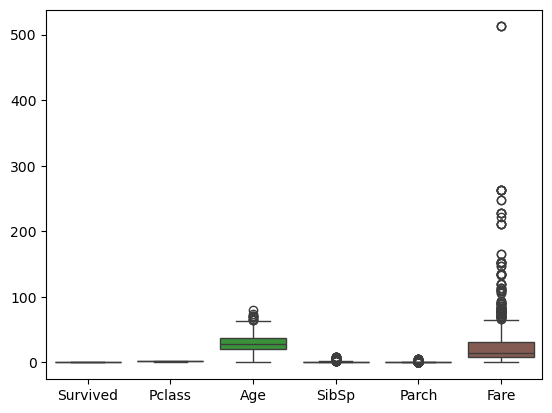

In [15]:
sns.boxplot(data=titanic)

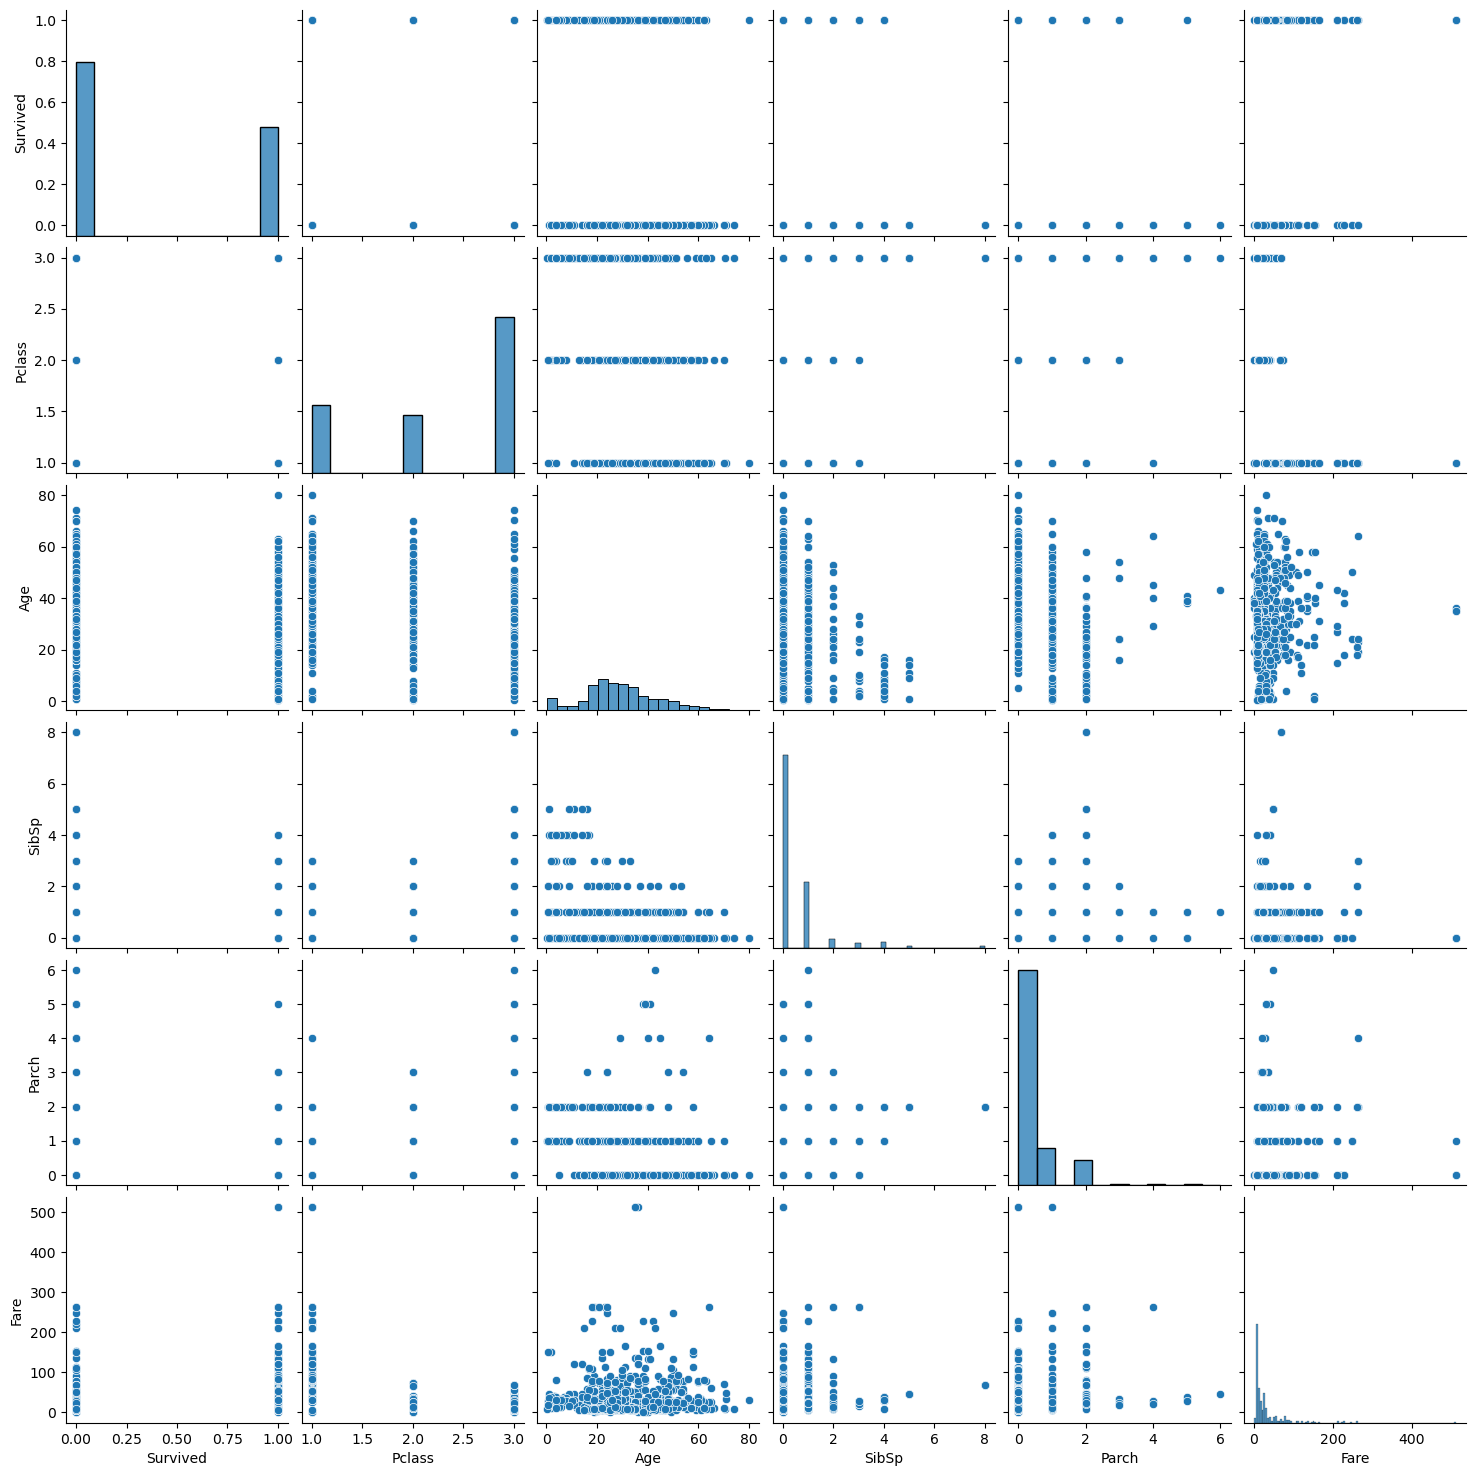

In [17]:
sns.pairplot(titanic)

## 2. Data preprocessing

#### Impute missing values

In [19]:
#imputation of null values
titanic["Age"]=titanic.Age.fillna(titanic.Age.median())
titanic["Embarked"]=titanic.Embarked.fillna(titanic.Embarked.mode()[0])

#### Encode categorical variables

In [21]:
label_encoder = preprocessing.LabelEncoder()
titanic['Sex']= label_encoder.fit_transform(titanic['Sex']) 
titanic['Embarked']= label_encoder.fit_transform(titanic['Embarked']) 

In [23]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int32  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    int32  
dtypes: float64(2), int32(2), int64(4)
memory usage: 48.9 KB


In [25]:
titanic.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.647587,29.361582,0.523008,0.381594,32.204208,1.536476
std,0.486592,0.836071,0.477990,13.019697,1.102743,0.806057,49.693429,0.791503
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.910400,1.000000
50%,0.000000,3.000000,1.000000,28.000000,0.000000,0.000000,14.454200,2.000000
75%,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,2.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000


#### Treating outliers

In [27]:
Q1 = titanic['Age'].quantile(0.25)
Q3 = titanic['Age'].quantile(0.75)
IQR = Q3 - Q1

# Determine bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Replace outliers
titanic['Age'] = titanic['Age'].clip(lower=lower_bound, upper=upper_bound)

In [29]:
Q1 = titanic['SibSp'].quantile(0.25)
Q3 = titanic['SibSp'].quantile(0.75)
IQR = Q3 - Q1

# Determine bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Replace outliers
titanic['SibSp'] = titanic['SibSp'].clip(lower=lower_bound, upper=upper_bound)

In [31]:
Q1 = titanic['Fare'].quantile(0.25)
Q3 = titanic['Fare'].quantile(0.75)
IQR = Q3 - Q1

# Determine bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Replace outliers
titanic['Fare'] = titanic['Fare'].clip(lower=lower_bound, upper=upper_bound)

<Axes: >

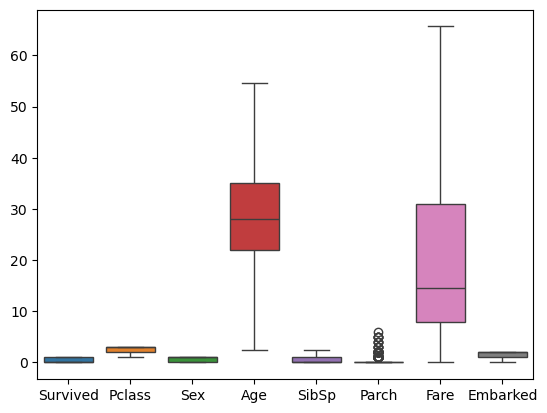

In [33]:
sns.boxplot(data=titanic)

In [35]:
titanic.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.647587,29.039282,0.426487,0.381594,24.046813,1.536476
std,0.486592,0.836071,0.477990,12.072074,0.708246,0.806057,20.481625,0.791503
min,0.000000,1.000000,0.000000,2.500000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.910400,1.000000
50%,0.000000,3.000000,1.000000,28.000000,0.000000,0.000000,14.454200,2.000000
75%,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,2.000000
max,1.000000,3.000000,1.000000,54.500000,2.500000,6.000000,65.634400,2.000000


## 3. Building predictive models

#### Split the data

In [37]:
# Dividing our data into input and output variables
X = titanic.iloc[:,1:]
Y = titanic.iloc[:,0]

In [39]:
Y.value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

#### Balance the data

In [41]:
smote = SMOTE(random_state=42)
# Fit and transform the training data
X1, Y1 = smote.fit_resample(X, Y)

In [43]:
Y1.value_counts()

Survived
0    549
1    549
Name: count, dtype: int64

In [45]:
# Splitting data into training and testing data set
x_train, x_test,y_train,y_test = train_test_split(X1, Y1, test_size=0.3,random_state=10)

In [47]:
print(x_train.shape,y_train.shape, x_test.shape, y_test.shape)

(768, 7) (768,) (330, 7) (330,)


In [49]:
y_train.value_counts()

Survived
0    394
1    374
Name: count, dtype: int64

#### XGBoost

In [51]:
model = XGBClassifier(n_estimator= 200, learning_rate= 0.1, max_depth= 5, subsample= 0.8)
model.fit(x_train, y_train)

C:\Users\hp\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:50:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimator=200, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

#### Model validation

In [53]:
print(classification_report(y_train,model.predict(x_train)))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       394
           1       0.95      0.90      0.92       374

    accuracy                           0.93       768
   macro avg       0.93      0.93      0.93       768
weighted avg       0.93      0.93      0.93       768



In [55]:
print(classification_report(y_test,model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       155
           1       0.91      0.82      0.86       175

    accuracy                           0.86       330
   macro avg       0.87      0.87      0.86       330
weighted avg       0.87      0.86      0.86       330



#### LightBGM

In [57]:
lgb_train = lgb.Dataset(x_train, label=y_train)
lgb_test = lgb.Dataset(x_test, label=y_test, reference= lgb_train)

In [59]:
params = {
    'objective': 'binary',        
    'metric': 'binary_logloss',    
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'n_estimators': 100,
    'bagging_fraction': 0.8,
    'feature_fraction': 0.8,
    'max_depth': -1,
    'min_child_samples': 20,
    'lambda_l1': 0.0,
    'lambda_l2': 0.1,
    'verbose': 0
}

In [61]:
model_lgb = lgb.LGBMClassifier(**params)
model_lgb.fit(x_train, y_train, eval_set=[(x_test, y_test)])

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: f

LGBMClassifier(bagging_fraction=0.8, feature_fraction=0.8, lambda_l1=0.0,
               lambda_l2=0.1, learning_rate=0.05, metric='binary_logloss',
               objective='binary', verbose=0)

#### Model validation

In [63]:
print(classification_report(y_train,model_lgb.predict(x_train)))

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       394
           1       0.93      0.88      0.90       374

    accuracy                           0.91       768
   macro avg       0.91      0.91      0.91       768
weighted avg       0.91      0.91      0.91       768



In [65]:
print(classification_report(y_test,model_lgb.predict(x_test)))

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       155
           1       0.91      0.82      0.86       175

    accuracy                           0.86       330
   macro avg       0.87      0.87      0.86       330
weighted avg       0.87      0.86      0.86       330



## 4. Comparative analysis

##### Model perfomance metrics of XGBM:
1. **Accuracy**= 0.86
2. **Precision**= 0- 0.82, 1- 0.91
3. **Recall**= 0- 0.91, 1- 0.82
4. **F1 score**= 0- 0.86, 1- 0.86

##### Model perfomance metrics of LGBM:
1. **Accuracy**= 0.86
2. **Precision**= 0- 0.82, 1- 0.91
3. **Recall**= 0- 0.91, 1- 0.82
4. **F1 score**= 0- 0.86, 1- 0.86   

#### ROC  curve for XGBM

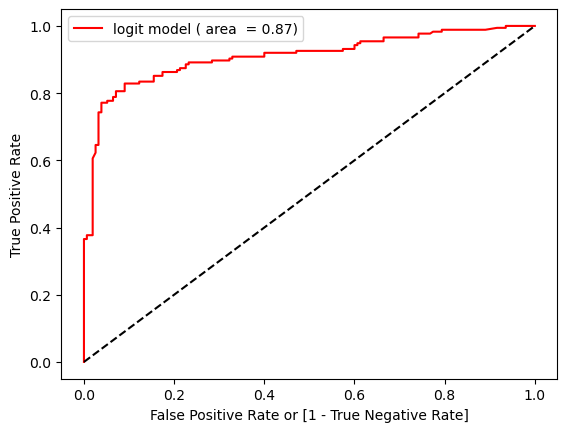

In [68]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba (x_test)[:,1])

auc =np.round( roc_auc_score(y_test, model.predict(x_test)),2)

import matplotlib.pyplot as plt
plt.plot(fpr, tpr, color='red', label=f'logit model ( area  = {auc})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

#### ROC curve for LGBM

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


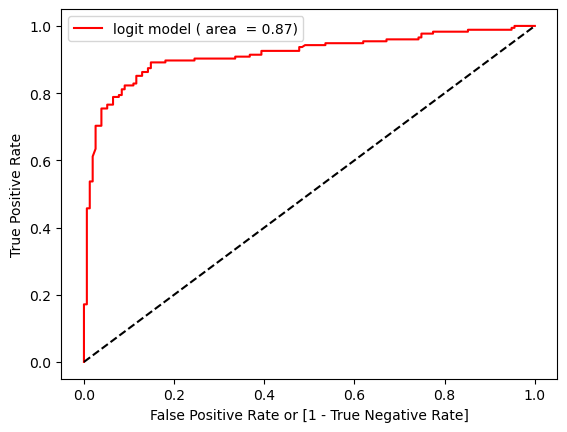

In [70]:
fpr, tpr, thresholds = roc_curve(y_test, model_lgb.predict_proba (x_test)[:,1])

auc =np.round( roc_auc_score(y_test, model_lgb.predict(x_test)),2)

import matplotlib.pyplot as plt
plt.plot(fpr, tpr, color='red', label=f'logit model ( area  = {auc})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

#### For Unseen data

In [69]:
titanic_test= pd.read_csv("C:\\Users\\hp\\Desktop\\EXCELR\\EXCELR\\XGBM & LGBM\\Titanic_test.csv")
titanic_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [71]:
titanic_test.drop(["PassengerId","Name","Ticket","Cabin"],inplace=True,axis = 1)

In [75]:
titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       332 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      417 non-null    float64
 6   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 23.0+ KB


#### Label encoder

In [77]:
label_encoder = preprocessing.LabelEncoder()
titanic_test['Sex']= label_encoder.fit_transform(titanic_test['Sex']) 
titanic_test['Embarked']= label_encoder.fit_transform(titanic_test['Embarked'])

In [79]:
titanic_test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,34.5,0,0,7.8292,1
1,3,0,47.0,1,0,7.0000,2
2,2,1,62.0,0,0,9.6875,1
3,3,1,27.0,0,0,8.6625,2
4,3,0,22.0,1,1,12.2875,2
...,...,...,...,...,...,...,...
413,3,1,NaN,0,0,8.0500,2
414,1,0,39.0,0,0,108.9000,0
415,3,1,38.5,0,0,7.2500,2
416,3,1,NaN,0,0,8.0500,2


In [81]:
titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    int32  
 2   Age       332 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      417 non-null    float64
 6   Embarked  418 non-null    int32  
dtypes: float64(2), int32(2), int64(3)
memory usage: 19.7 KB


#### Handle missing values

In [83]:
titanic_test["Age"]=titanic_test.Age.fillna(titanic.Age.median())
titanic_test["Fare"]=titanic_test.Fare.fillna(titanic.Fare.median())

In [85]:
titanic_test.describe()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,2.265550,0.636364,29.805024,0.447368,0.392344,35.576535,1.401914
std,0.841838,0.481622,12.667969,0.896760,0.981429,55.850103,0.854496
min,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,23.000000,0.000000,0.000000,7.895800,1.000000
50%,3.000000,1.000000,28.000000,0.000000,0.000000,14.454200,2.000000
75%,3.000000,1.000000,35.750000,1.000000,0.000000,31.471875,2.000000
max,3.000000,1.000000,76.000000,8.000000,9.000000,512.329200,2.000000


<Axes: >

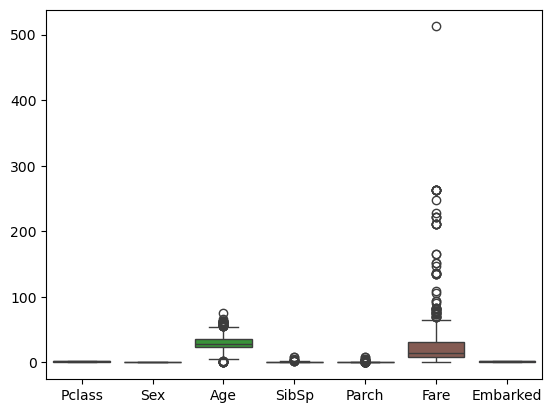

In [87]:
sns.boxplot(titanic_test)

#### Treating outliers

In [89]:
# Calculate Q1, Q3, and IQR
Q1 = titanic_test['Age'].quantile(0.25)
Q3 = titanic_test['Age'].quantile(0.75)
IQR = Q3 - Q1

# Determine bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Replace outliers
titanic_test['Age'] = titanic_test['Age'].clip(lower=lower_bound, upper=upper_bound)

In [91]:
# Calculate Q1, Q3, and IQR
Q1 = titanic_test['SibSp'].quantile(0.25)
Q3 = titanic_test['SibSp'].quantile(0.75)
IQR = Q3 - Q1

# Determine bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Replace outliers
titanic_test['SibSp'] = titanic_test['SibSp'].clip(lower=lower_bound, upper=upper_bound)

In [93]:
#Calculate Q1, Q3, and IQR
Q1 = titanic_test['Fare'].quantile(0.25)
Q3 = titanic_test['Fare'].quantile(0.75)
IQR = Q3 - Q1

# Determine bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Replace outliers
titanic_test['Fare'] = titanic_test['Fare'].clip(lower=lower_bound, upper=upper_bound)

<Axes: >

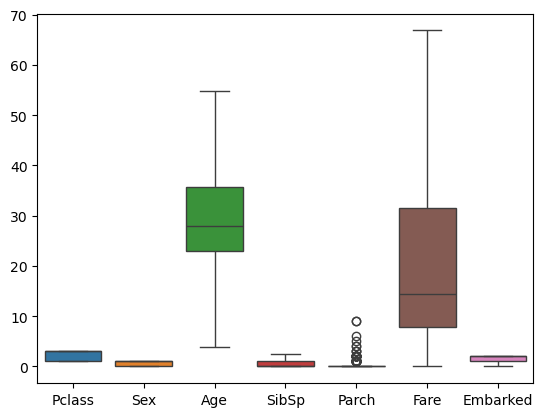

In [95]:
sns.boxplot(titanic_test)

***Here, In titanic_test data there are no dependent variable present so we can't validate our model we only can predict the values using our pre determined model for XGBM and LGBM.***

#### XGBM

In [99]:
y_pred_XG= model.predict(titanic_test)
y_pred_XG

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

#### LGBM

In [104]:
y_pred_LG=model_lgb.predict(titanic_test)
y_pred_LG

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,